In [1]:
import os
import tarfile
import urllib.request


import scipy.io
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random
from PIL import Image

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
import tensorflow.keras.backend as K
from tensorflow import keras
from keras import ops
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Lambda, Dropout, Flatten, GlobalAveragePooling2D, Concatenate

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import itertools
from sklearn.metrics.pairwise import cosine_similarity

# 🔹 Step 1: Load & Explore the Dataset

## 📌 Step 1.1: Download the Dataset

In [2]:
# URL of the dataset
dataset_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz"
labels_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat"

# Define download paths
dataset_path = "./102flowers.tgz"
labels_path = "./imagelabels.mat"
data_dir = "./102flowers/"

image_size = (224, 224)

# Function to download dataset
def download_dataset(url, save_path):
    if not os.path.exists(save_path):
        print(f"Downloading {url}...")
        urllib.request.urlretrieve(url, save_path)
        print("Download completed!")

# Download images and labels
download_dataset(dataset_url, dataset_path)
download_dataset(labels_url, labels_path)

# Extract dataset
if not os.path.exists(data_dir):
    print("Extracting dataset...")
    with tarfile.open(dataset_path, "r:gz") as tar:
        tar.extractall(path=data_dir)
    print("Extraction completed!")

Download completed!
Download completed!
Extracting dataset...
Extraction completed!


## 📌 Step 1.2: Load Image Labels

In [3]:
# Load image labels
mat = scipy.io.loadmat(labels_path)
labels = mat["labels"][0]  # Extract labels

# Convert labels to zero-indexed format (original is 1-102)
labels = labels - 1

print(f"Total Images: {len(labels)}")
print(f"Unique Classes: {len(set(labels))}")

Total Images: 8189
Unique Classes: 102


## 📌 Step 1.3: Creating Sub-Samples for Smallest Dataset

In [4]:
# Get all image file names
data_dir = '/content/102flowers/jpg/'
image_files = sorted(os.listdir(data_dir))

# Pair image paths with their labels
data = [(os.path.join(data_dir, img), label) for img, label in zip(image_files, labels)]

# Convert unique labels into a sorted list
unique_classes = sorted(list(set(labels)))

# Randomly select 10 classes for Sub-Samples
selected_classes = random.sample(unique_classes, 10)

# Filter dataset to only include selected classes
filtered_data = [(img_path, label) for img_path, label in data if label in selected_classes]

# Create label mapping (assign new indices 0-9)
label_map = {cls: idx for idx, cls in enumerate(selected_classes)}

# Update dataset with new mapped labels
final_data = [(img_path, label_map[label]) for img_path, label in filtered_data]

# Shuffle the final dataset
random.shuffle(final_data)

# Display information
print(f"Selected Classes: {selected_classes}")
print(f"Total Samples in Smallest Dataset: {len(final_data)}")

Selected Classes: [100, 66, 9, 0, 7, 101, 21, 56, 11, 90]
Total Samples in Smallest Dataset: 607


## 📌 Step 1.4: Display Sample Images

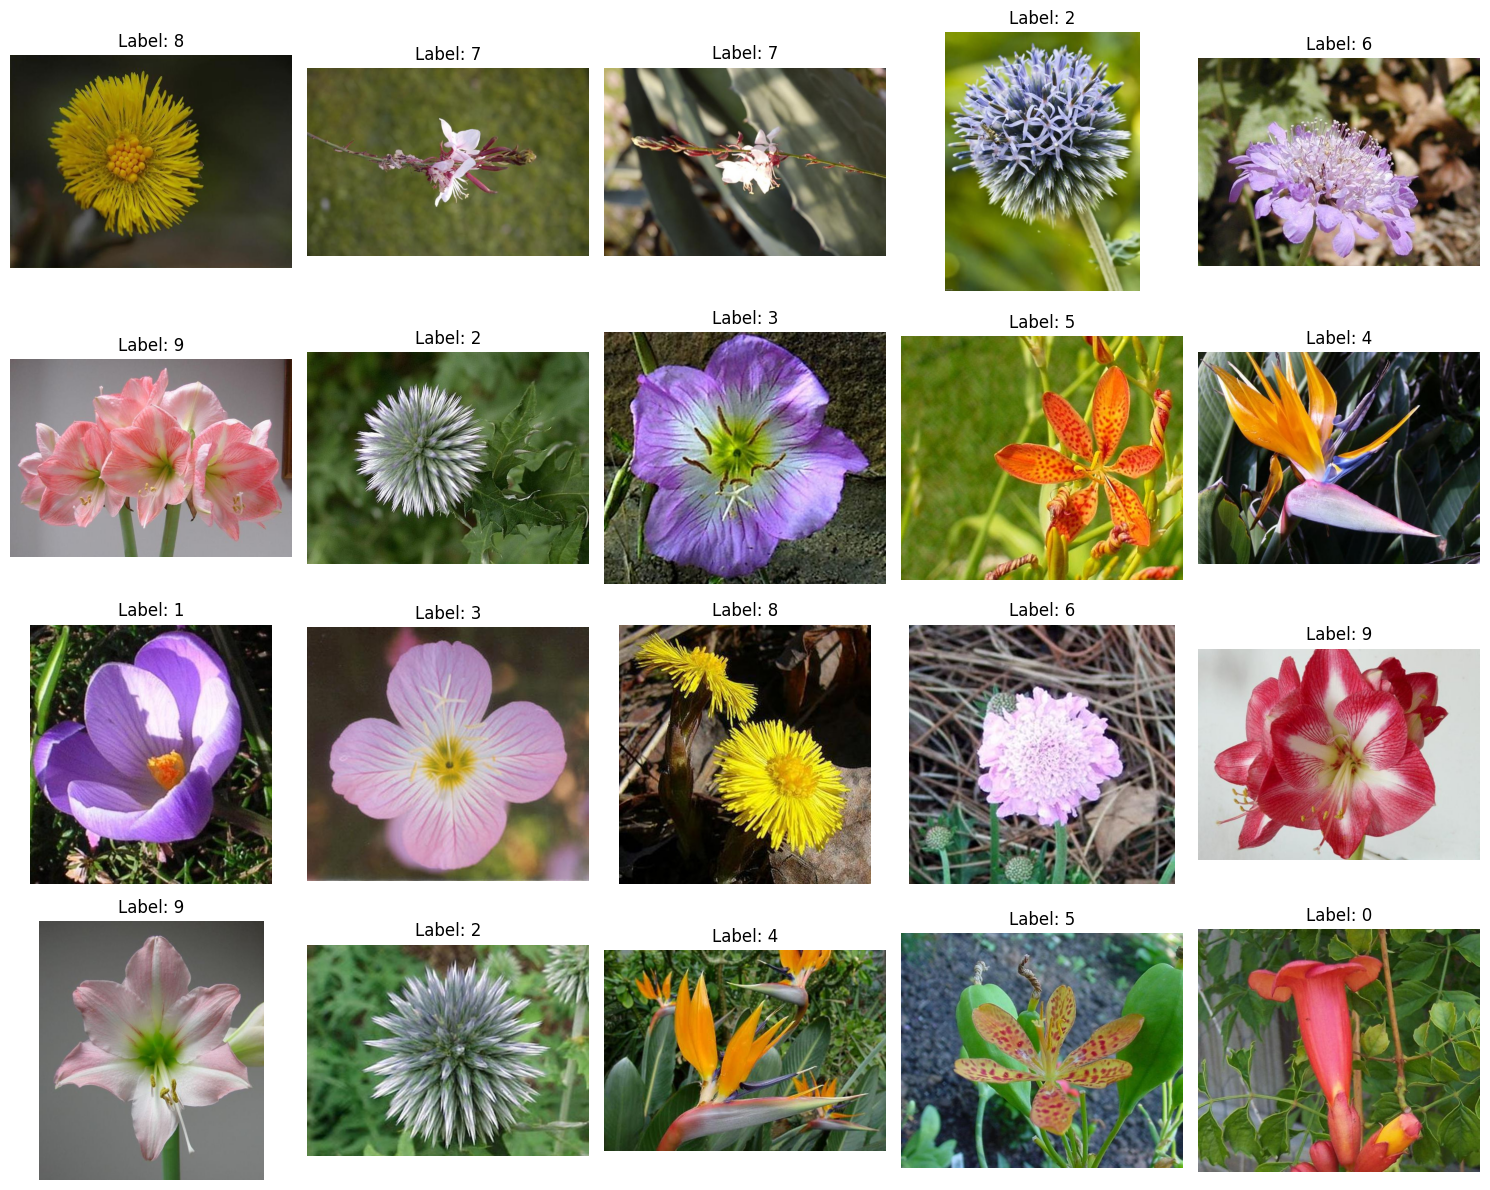

In [5]:
# Select 20 random samples from final_data
sample_images = random.sample(final_data, 20)

# Create a figure with 4 rows and 5 columns
fig, axes = plt.subplots(4, 5, figsize=(15, 12))

# Loop through selected images and display them
for ax, (image_path, label) in zip(axes.flatten(), sample_images):
    img = Image.open(image_path)  # Open image
    ax.imshow(img)  # Show image
    ax.set_title(f"Label: {label}")  # Display label as title
    ax.axis("off")  # Hide axis

plt.tight_layout()
plt.show()


## 📌 Step 1.5: Providing Support Set and Query Set

In [6]:
# Ensure selected_classes from smallest dataset is excluded
remaining_classes = [cls for cls in unique_classes if cls not in selected_classes]

# Randomly select 3 classes for the 3-way support set
support_classes = random.sample(remaining_classes, 3)

# Select 3 images per class for the support set (keep original labels)
support_set = []
for cls in support_classes:
    cls_images = [img for img in data if img[1] == cls]
    selected_images = random.sample(cls_images, 3)  # Pick 3 images
    support_set.extend(selected_images)

# Select 1 image from each of the 3 support classes for the query set
query_set = []
for cls in support_classes:
    cls_images = [img for img in data if img[1] == cls and img not in support_set]
    if cls_images:
        query_set.append(random.choice(cls_images))  # Pick 1 image per class

# Select 1 more image from one of the 3 support classes to make total 4 images
extra_class = random.choice(support_classes)
extra_images = [img for img in data if img[1] == extra_class and img not in support_set and img not in query_set]

if extra_images:
    query_set.append(random.choice(extra_images))

# Shuffle the sets
# random.shuffle(support_set)
# random.shuffle(query_set)

# Display the Support Set
print("\nSupport Set (3-way, 3-shot):")
for img_path, label in support_set:
    print(f"Image: {img_path}, Original Label: {label}")

# Display the Query Set (now exactly 4 images)
print("\nQuery Set (4 images):")
for img_path, label in query_set:
    print(f"Image: {img_path}, Original Label: {label}")


Support Set (3-way, 3-shot):
Image: /content/102flowers/jpg/image_04910.jpg, Original Label: 19
Image: /content/102flowers/jpg/image_04930.jpg, Original Label: 19
Image: /content/102flowers/jpg/image_04905.jpg, Original Label: 19
Image: /content/102flowers/jpg/image_05852.jpg, Original Label: 62
Image: /content/102flowers/jpg/image_05882.jpg, Original Label: 62
Image: /content/102flowers/jpg/image_05849.jpg, Original Label: 62
Image: /content/102flowers/jpg/image_06228.jpg, Original Label: 48
Image: /content/102flowers/jpg/image_06207.jpg, Original Label: 48
Image: /content/102flowers/jpg/image_06241.jpg, Original Label: 48

Query Set (4 images):
Image: /content/102flowers/jpg/image_04926.jpg, Original Label: 19
Image: /content/102flowers/jpg/image_05883.jpg, Original Label: 62
Image: /content/102flowers/jpg/image_06237.jpg, Original Label: 48
Image: /content/102flowers/jpg/image_04897.jpg, Original Label: 19


## 📌 Step 1.6: Visualizing Support Set and Query Set

In [ ]:
# Function to display images in grid format
def show_images(image_paths, labels, title, rows=1, cols=3, figsize=(10, 5)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    fig.suptitle(title, fontsize=14)

    if rows == 1:  # If only one row, `axes` is 1D
        axes = [axes]

    for idx, (img_path, label) in enumerate(zip(image_paths, labels)):
        img = cv2.imread(img_path)  # Read the image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = cv2.resize(img, (224, 224))  # Resize for consistency

        row, col = divmod(idx, cols)  # Determine grid position
        axes[row][col].imshow(img)
        axes[row][col].axis("off")
        axes[row][col].set_title(f"Label: {label}")

    plt.tight_layout()
    plt.show()

# Extract support set images and labels
support_paths = [img_path for img_path, label in support_set]
support_labels = [label for img_path, label in support_set]

# Extract query set images and labels
query_paths = [img_path for img_path, label in query_set]
query_labels = [label for img_path, label in query_set]

# Show Support Set
print("\nVisualizing Support Set:")
show_images(support_paths, support_labels, title="Support Set (3-way, 3-shot)", rows=3, cols=3, figsize=(10, 10))

# Show Query Set
print("\nVisualizing Query Set:")
show_images(query_paths, query_labels, title="Query Set (4 images)", rows=1, cols=4, figsize=(12, 4))


Visualizing Support Set:


In [ ]:
# Create label mapping (assign 0, 1, 2 to the support classes)
label_map = {cls: idx for idx, cls in enumerate(support_classes)}

# Apply label mapping
mapped_support_set = [(img_path, label_map[label]) for img_path, label in support_set]
mapped_query_set = [(img_path, label_map[label]) for img_path, label in query_set]

# Display the Support Set (after mapping)
print("\nSupport Set (3-way, 3-shot) - Mapped Labels (0,1,2):")
for img_path, label in mapped_support_set:
    print(f"Image: {img_path}, Mapped Label: {label}")

# Display the Query Set (after mapping)
print("\nQuery Set (4 images) - Mapped Labels (0,1,2):")
for img_path, label in mapped_query_set:
    print(f"Image: {img_path}, Mapped Label: {label}")

# 🔹 Step 2: Feature Extraction using ResNet50

In [ ]:
# Load ResNet50 and freeze layers
def build_feature_extractor():
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation="relu")(x)
    x = Dense(64, activation="relu")(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

feature_extractor = build_feature_extractor()
feature_extractor.summary()

# 🔹Step 3: Image Preprocessing and Data Splitting

In [10]:
def preprocess_image(image_path):
    """Load and preprocess image."""
    img = load_img(image_path, target_size=image_size)
    img = img_to_array(img) / 255.0  # Normalize
    return img

# Load images and labels
X = np.array([preprocess_image(img_path) for img_path, _ in final_data])
y = np.array([label for _, label in final_data])

In [11]:
# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
del X, y

# 🔹 Step 3: Creating Triplet for Siamese Network

In [12]:
def create_triplets(images, labels):
    """Generate triplets (anchor, positive, negative) for training."""
    triplets = []
    num_classes = len(np.unique(labels))

    for idx in range(len(images)):
        anchor_img = images[idx]
        anchor_label = labels[idx]

        # Select a positive sample (same class as anchor)
        pos_idx = np.random.choice(np.where(labels == anchor_label)[0])
        pos_img = images[pos_idx]

        # Select a negative sample (different class)
        neg_label = (anchor_label + np.random.randint(1, num_classes)) % num_classes
        neg_idx = np.random.choice(np.where(labels == neg_label)[0])
        neg_img = images[neg_idx]

        triplets.append([anchor_img, pos_img, neg_img])

    return np.array(triplets)

In [13]:
# Generate triplets
triplets_train = create_triplets(X_train, y_train)
triplets_val = create_triplets(X_val, y_val)
del X_train, y_train, X_val, y_val

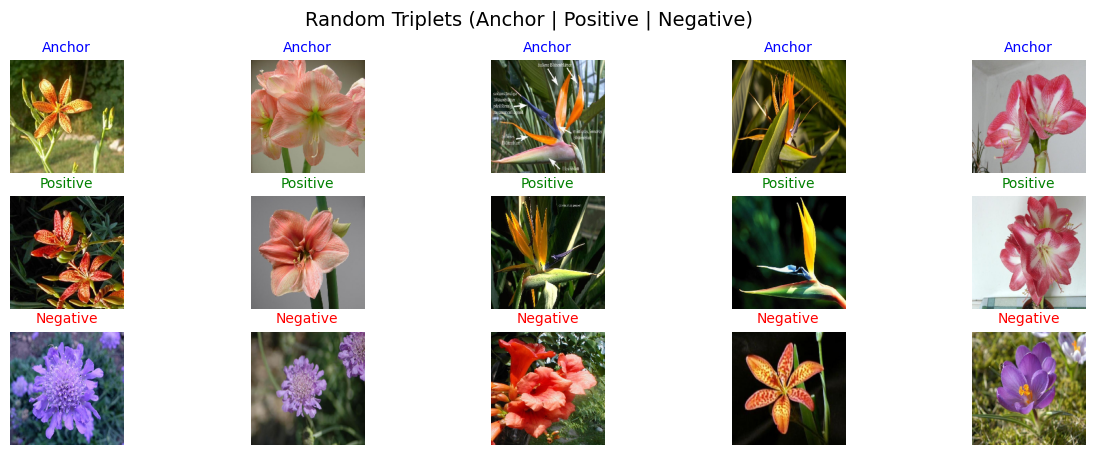

In [14]:
def show_random_triplets(triplets, num_samples=5):
    """
    Display a few random triplet samples (Anchor, Positive, Negative).

    Args:
    - triplets: NumPy array of triplets (anchor, positive, negative).
    - num_samples: Number of triplets to display.
    """
    num_samples = min(num_samples, len(triplets))  # Ensure we don't exceed available samples
    random_indices = np.random.choice(len(triplets), num_samples, replace=False)  # Randomly select indices

    plt.figure(figsize=(num_samples * 3, 5))  # Set figure size dynamically

    for i, idx in enumerate(random_indices):
        anchor, positive, negative = triplets[idx]

        # Plot Anchor
        plt.subplot(3, num_samples, i + 1)
        plt.imshow(anchor)
        plt.title("Anchor", fontsize=10, color="blue")
        plt.axis("off")

        # Plot Positive (same class as anchor)
        plt.subplot(3, num_samples, i + 1 + num_samples)
        plt.imshow(positive)
        plt.title("Positive", fontsize=10, color="green")
        plt.axis("off")

        # Plot Negative (different class)
        plt.subplot(3, num_samples, i + 1 + 2 * num_samples)
        plt.imshow(negative)
        plt.title("Negative", fontsize=10, color="red")
        plt.axis("off")

    plt.suptitle("Random Triplets (Anchor | Positive | Negative)", fontsize=14)
    plt.show()

# Call the function to visualize random triplets
show_random_triplets(triplets_train, num_samples=5)  # Show 5 random triplets

In [15]:
# Extract anchor, positive, and negative images
X_train_anchor = triplets_train[:, 0]
X_train_pos = triplets_train[:, 1]
X_train_neg = triplets_train[:, 2]
del triplets_train

X_val_anchor = triplets_val[:, 0]
X_val_pos = triplets_val[:, 1]
X_val_neg = triplets_val[:, 2]
del triplets_val

# 🔹 Step 5: Siamese Network Model

In [16]:
import tensorflow.keras.backend as K

def triplet_loss(y_true, y_pred, alpha=0.2):
    """Triplet loss function (y_pred contains distances: d_ap, d_an)."""
    anchor_positive_distance = y_pred[:, 0]  # Distance between anchor & positive
    anchor_negative_distance = y_pred[:, 1]  # Distance between anchor & negative

    return K.mean(K.maximum(anchor_positive_distance - anchor_negative_distance + alpha, 0.0))


def euclidean_distance(vectors):
    """Compute Euclidean distance with numerical stability."""
    x, y = vectors
    return K.expand_dims(K.sqrt(K.sum(K.square(x - y), axis=-1) + K.epsilon()), axis=-1)


In [17]:
def build_triplet_network():
    """Create a Triplet Network model."""
    input_shape = (224, 224, 3)

    # Inputs for anchor, positive, and negative
    input_anchor = Input(shape=input_shape)
    input_pos = Input(shape=input_shape)
    input_neg = Input(shape=input_shape)

    # Shared feature extractor (ResNet50)
    feature_extractor = build_feature_extractor()  # Keeping layers frozen
    encoded_anchor = feature_extractor(input_anchor)
    encoded_pos = feature_extractor(input_pos)
    encoded_neg = feature_extractor(input_neg)

    # Compute distances
    d_ap = Lambda(euclidean_distance)([encoded_anchor, encoded_pos])  # Anchor-Positive Distance
    d_an = Lambda(euclidean_distance)([encoded_anchor, encoded_neg])  # Anchor-Negative Distance
    distances = Concatenate()([d_ap, d_an])  # Combine into a single tensor

    # Model
    model = Model(inputs=[input_anchor, input_pos, input_neg], outputs=distances)

    # Compile with triplet loss
    model.compile(loss=triplet_loss, optimizer=keras.optimizers.Adam(learning_rate=1e-4))

    return model

# Create and compile the model
triplet_model = build_triplet_network()
triplet_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_1 (Functional) │ (None, 64)             │     23,858,240 │ input_layer_1[0][0],   │
│                           │                        │                │ input_layer_2[0][0],   │
│                           │                        │                │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 1)              │              0 │ functional_1[0][0],    │
│                           │                        │                │ functional_1[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 1)              │              0 │ functional_1[0][0],    │
│                           │                        │                │ functional_1[2][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 2)              │              0 │ lambda[0][0],          │
│                           │                        │                │ lambda_1[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,858,240 (91.01 MB)

 Trainable params: 270,528 (1.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## 📌 Step 5.1: model Training

In [18]:
history = triplet_model.fit(
    [X_train_anchor, X_train_pos, X_train_neg],  # Three inputs
    np.zeros(len(X_train_anchor)),  # Dummy labels (not used in triplet loss)
    validation_data=([X_val_anchor, X_val_pos, X_val_neg], np.zeros(len(X_val_anchor))),
    epochs=50,
    batch_size=32
)


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - loss: 0.1884 - val_loss: 0.1607
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 293ms/step - loss: 0.1700 - val_loss: 0.1475
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 307ms/step - loss: 0.1557 - val_loss: 0.1430
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 288ms/step - loss: 0.1422 - val_loss: 0.1374
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 291ms/step - loss: 0.1313 - val_loss: 0.1370
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 293ms/step - loss: 0.1311 - val_loss: 0.1325
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 301ms/step - loss: 0.1269 - val_loss: 0.1305
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 303ms/step - loss: 0.1201 - val_loss: 0.1309
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 352ms/step - loss: 0.1116 - val_loss: 0.1294
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 326ms/step - loss: 0.1202 - val_loss: 0.1271
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 299ms/step - loss: 0.1112 - val_loss: 0.1277
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step

## 📌Step 5.2: Fine Tuning

In [19]:
'''
# Unfreeze the last few layers of ResNet50 inside the trained model
for layer in siamese_model.layers[2].layers[-2:]:  # Feature extractor is the 3rd layer (index 2)
    layer.trainable = True

# Compile again with a lower learning rate
siamese_model.compile(loss=contrastive_loss, optimizer=keras.optimizers.Adam(learning_rate=1e-5))
'''
# Print model summary to verify trainable layers
triplet_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_1 (Functional) │ (None, 64)             │     23,858,240 │ input_layer_1[0][0],   │
│                           │                        │                │ input_layer_2[0][0],   │
│                           │                        │                │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 1)              │              0 │ functional_1[0][0],    │
│                           │                        │                │ functional_1[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 1)              │              0 │ functional_1[0][0],    │
│                           │                        │                │ functional_1[2][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 2)              │              0 │ lambda[0][0],          │
│                           │                        │                │ lambda_1[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 24,399,298 (93.08 MB)

 Trainable params: 270,528 (1.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 541,058 (2.06 MB)

In [20]:
# Extract support images and labels
support_images = np.array([preprocess_image(img_path) for img_path, _ in mapped_support_set])
support_labels = np.array([label for _, label in mapped_support_set])

# Generate triplets from support set
support_triplets = create_triplets(support_images, support_labels)

# Extract triplet components
support_anchor = np.stack(support_triplets[:, 0], axis=0)
support_pos = np.stack(support_triplets[:, 1], axis=0)
support_neg = np.stack(support_triplets[:, 2], axis=0)

In [21]:
# Fine-tune using support set
triplet_model.fit(
    [support_anchor, support_pos, support_neg],
    np.zeros(len(support_anchor)),
    epochs=10,  # Fewer epochs to avoid overfitting
    batch_size=8,
    verbose=1
)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 7s/step - loss: 0.1676
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.1580
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.1204 
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1088 
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0798 
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0559 
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0491 
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0327 
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0261 
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0129     


# 🔹 Step 6: Inference Phase

## 📌 Step 6.1: Preparing Support and Query Sets

In [22]:
# Extract support images and labels
mapped_support_set_path = [mapped_support_set_path for mapped_support_set_path, _ in mapped_support_set]
mapped_support_set_label = [mapped_support_set_label for  _, mapped_support_set_label in mapped_support_set]
mapped_query_set_path =  [mapped_query_set_path for mapped_query_set_path, _ in mapped_query_set]

In [23]:
def prepare_manual_support_set(support_image_paths, support_labels):
    """
    Preprocess support images and convert labels to NumPy arrays.
    """
    support_images = [preprocess_image(img) for img in support_image_paths]
    support_images = np.stack(support_images)  # Convert to NumPy array
    support_labels = np.array(support_labels)  # Convert labels to NumPy array
    return support_images, support_labels

# Load support set
support_images, support_labels = prepare_manual_support_set(mapped_support_set_path, mapped_support_set_label)
print(f"Support Images Shape: {support_images.shape}, Labels Shape: {support_labels.shape}")

Support Images Shape: (9, 224, 224, 3), Labels Shape: (9,)


In [24]:
def prepare_query_images(query_image_paths):
    """
    Preprocess query images.
    """
    query_images = [preprocess_image(img) for img in query_image_paths]
    return np.stack(query_images)

# Load query images
query_images = prepare_query_images(mapped_query_set_path)
print(f"Query Images Shape: {query_images.shape}")

Query Images Shape: (4, 224, 224, 3)


## 📌 Step 6.2: Extract Embeddings

In [25]:
# ------------------ Extract Embeddings ------------------

def extract_embeddings(model, images):
    """
    Extract feature embeddings using the trained triplet network's feature extractor.
    """
    feature_extractor = model.get_layer(index=3)  # Adjust index based on actual structure
    return feature_extractor.predict(images)  # Now correctly extracting embeddings

# Extract support embeddings
support_embeddings = extract_embeddings(triplet_model, support_images)
print(f"Support Embeddings Shape: {support_embeddings.shape}")

# Extract query embeddings
query_embeddings = extract_embeddings(triplet_model, query_images)
print(f"Query Embeddings Shape: {query_embeddings.shape}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Support Embeddings Shape: (9, 64)
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Query Embeddings Shape: (4, 64)


## 📌 Step 6.2: Prediction Phase

In [26]:
def predict_query_image(query_embedding, support_embeddings, support_labels):
    """
    Predict the class of a single query image using the nearest support image in embedding space.
    """
    distances = np.linalg.norm(support_embeddings - query_embedding, axis=1)  # Euclidean distance
    best_match_idx = np.argmin(distances)  # Find the closest support sample
    best_match_label = support_labels[best_match_idx]  # Get the label

    return best_match_label, distances  # Returning distances for debugging



In [27]:
# Perform classification on the query set
predicted_labels = []
for i, query_embedding in enumerate(query_embeddings):
    predicted_label, distances = predict_query_image(query_embedding, support_embeddings, support_labels)
    predicted_labels.append(predicted_label)
    print(f"Query Image {i+1} classified as Class {predicted_label}, Distances: {distances}")

Query Image 1 classified as Class 0, Distances: [0.43996087 0.3941372  0.4674348  0.510664   0.63008225 0.75878346
 0.85086375 1.0156219  0.76585203]
Query Image 2 classified as Class 1, Distances: [0.22270943 0.3909833  0.4200313  0.1861679  0.22508547 0.34065077
 0.5963178  0.7523191  0.6187777 ]
Query Image 3 classified as Class 1, Distances: [0.40619022 0.41318068 0.42601925 0.35578105 0.36686096 0.4208981
 0.47968817 0.6694441  0.47541082]
Query Image 4 classified as Class 0, Distances: [0.38988099 0.36296737 0.3274344  0.45443898 0.650615   0.8168675
 0.9498176  1.1167651  0.8677904 ]


In [28]:
print("Predicted Labels for Query Set:", predicted_labels)

Predicted Labels for Query Set: [0, 1, 1, 0]


## 📌 Step 6.3: Comparing Predicted label and Actual Class

---



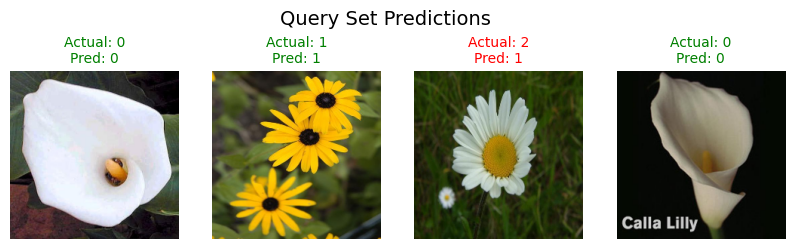

In [29]:
# Number of query images
num_queries = len(mapped_query_set)

# Set up figure size dynamically
plt.figure(figsize=(num_queries * 2.5, 3))

# Iterate over query images and their predicted labels
for i, ((img_path, actual_label), predicted_label) in enumerate(zip(mapped_query_set, predicted_labels)):
    img = cv2.imread(img_path)  # Load image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))  # Resize to match input size

    # Define title color (green for correct, red for incorrect)
    title_color = "green" if actual_label == predicted_label else "red"

    plt.subplot(1, num_queries, i + 1)  # Create subplot for each query image
    plt.imshow(img)
    plt.title(f'Actual: {actual_label}\nPred: {predicted_label}', fontsize=10, color=title_color)
    plt.axis('off')

plt.suptitle("Query Set Predictions", fontsize=14)
plt.show()